In [1]:
import torch
import torchmetrics.classification as tc
import torchvision as tv
import os
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torchaudio.transforms as T
from torch.utils.tensorboard import SummaryWriter

from functions.dl.convenience_functions import to_device, trialDir
from functions.dl.data_classes import SpectroDataset, CombinedSpectroDataset, SpectroDataLoader
from functions.dl.data_functions import splitDataset, load_data, load_model, train_model, getBestModel
from functions.dl.network_components import EarlyStopping, AudioToLogSpectrogram

CUDA_LAUNCH_BLOCKING=1
TORCH_USE_CUDA_DSA = 1
%load_ext tensorboard

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
def getSamples(split : list, sizes : list = [None, None, None]):
    """
        Computes the indices for the datasets used in the dataloader. Intended to be used after the splitDataset method.

        Inputs:
            split : list - list containing indices of the train, test and val splits
            sizes : list - list containing the number of samples. Uses absolute samples when given an int, percentage for float <= 1 and all sample for None type

        Outputs: 
            samples : list - list containing the split indices
    """
    samples = []
    for idx, data in enumerate(split):
        data_indices = []
        if type(sizes[idx]) is int:
            data_indices = split[idx][:sizes[idx]]
        elif (type(sizes[idx]) is float and sizes[idx] <= 1.0):
            indices = round(len(split[idx])*sizes[idx])
            data_indices = split[idx][:indices]
        elif sizes[idx] is None:
            data_indices = split[idx]
        
        samples.append(data_indices)
        
    return samples

In [4]:
# File locations for the label files
# Simple dataset
recording_path= "F:\\Persönliches\\Git\\BioOTon\\AudioTensors_denoised"# "F:\\Persönliches\\Git\\BioOTon\\AudioTensors_freq"# "F:\\Persönliches\\Git\\BioOTon\\AudioTensors"
label_path="F:\\Persönliches\\Git\\BioOTon"
# Combined dataset
dawn_file = "F:/Persönliches/Git/BioOTon/points_single.parquet"
xeno_file = "F:/Persönliches/Git/BioOTon/xeno_points_single.parquet"
augmented_file = "F:/Persönliches/Git/BioOTon/augmented_points_single.parquet"



# The train - test - validation split
train_split_pct = 0.7
val_split_pct = 0.1
test_split_pct = 1.0 - train_split_pct - val_split_pct

# If and how many samples to take from the dataset
train_sample_size = 0.01
test_sample_size = 0.1
val_sample_size = 0.01

# Load  dataset

# ds = SpectroDataset(recording_path, label_path, device = 'cuda', denoised = True, filtered=False)
ds = CombinedSpectroDataset(dawn_file, xeno_file, augmented_file, device = device, denoised = True)

# Get samples and split the dataset
split = splitDataset(ds, test_split_size=val_split_pct, val_split_size=test_split_pct)
train_indices, test_indices, val_indices = getSamples(split, sizes = [train_sample_size, test_sample_size, val_sample_size])

In [5]:
batch_size = 128
train_dataloader = SpectroDataLoader(ds, batch_size, samples= train_indices, device = "cuda")

In [6]:
val_dataloader = SpectroDataLoader(ds, batch_size, samples= val_indices, device = "cuda")

In [7]:
test_dataloader = SpectroDataLoader(ds, batch_size, samples= test_indices, device = "cuda")

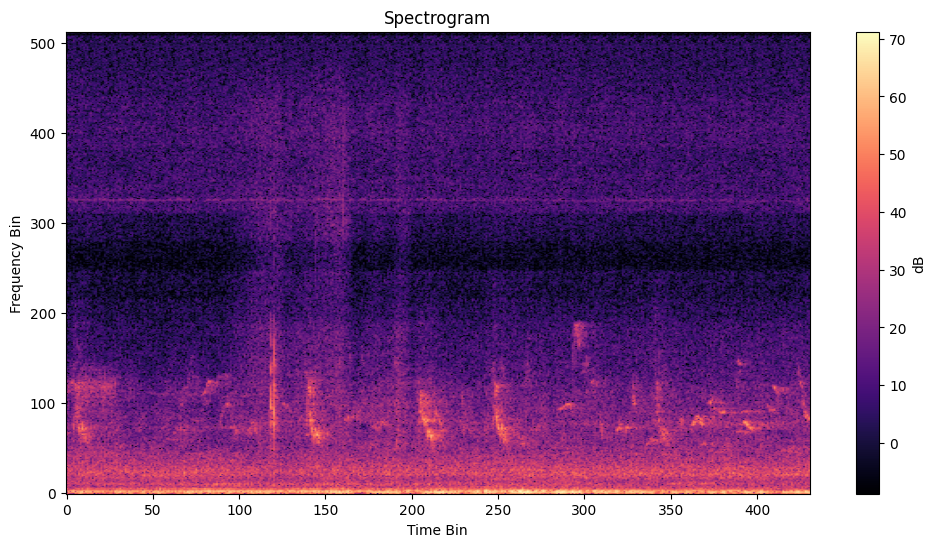

In [ ]:
waveform = next(iter(train_dataloader))[0][1]

spectrogram_transform = T.Spectrogram(
    n_fft=1024, 
    hop_length=512, 
    power=2
)

spec = spectrogram_transform(waveform.cpu()) 

spec_db = T.AmplitudeToDB(stype='power', top_db=80)(spec)

plt.figure(figsize=(12, 6))
plt.imshow(
    spec_db.numpy(), 
    origin='lower', 
    aspect='auto', 
    cmap='magma'
)
plt.colorbar(label='dB')
plt.title("Spectrogram")
plt.ylabel("Frequency Bin")
plt.xlabel("Time Bin")
plt.show()

In [8]:
atls = AudioToLogSpectrogram(device = "cuda")
res = tv.models.resnet18()
adaptconv1 = nn.Conv2d (in_channels=1, kernel_size=res.conv1.kernel_size, stride=res.conv1.stride, padding = res.conv1.padding, bias=res.conv1.bias, out_channels=res.conv1.out_channels)
res.conv1 = adaptconv1
res.fc = nn.Linear(in_features=res.fc.in_features, out_features=37, bias=True)

nnw = nn.Sequential(atls, res)

to_device(nnw, device)

Sequential(
  (0): AudioToLogSpectrogram(
    (spec): Spectrogram()
    (amplitude_to_db): AmplitudeToDB()
  )
  (1): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [9]:
epochs = 40
batch_prints = batch_size
writer = SummaryWriter("runs/single_points")
networkPath = f"F:\\Persönliches\\Git\\BioOTon\\checkpoints\\checkpoint_test_data_augmentation.pt"
lr = 0.0001

# Parameters for the ElasticNet penalty
l1_lambda = 0.002
l2_lambda = 0.0015

loss = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=7, delta=0.1, model = nnw)

# fused doesn't work without cuda
if device == 'cuda':
    optimizer = optim.Adam(nnw.parameters(), lr=lr, fused=True)
else:
    optimizer = optim.Adam(nnw.parameters(), lr=lr)

# Train the network
for epoch in range(epochs):  # loop over the dataset multiple times
    nnw.train()
    running_loss = 0.0
    # i = 0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        outputs = nnw(inputs)

        labels_long = labels.type(torch.LongTensor)
        labels_long = to_device(labels_long.long(), device)
        # print(f"Batch Label Min: {labels_long.min()}, Max: {labels_long.max()}")

        los = loss(outputs, labels_long)


        l1_penalty = 0
        l2_penalty = 0

        # L1 and L 2Regularization
        for p in nnw.parameters():
            l1_penalty += p.abs().sum()
            l2_penalty += p.pow(2.0).sum()

        # Elastic Net Penalty
        elastic_penalty = l1_lambda * l1_penalty + l2_lambda * l2_penalty

        los += elastic_penalty

        # Clear the gradients
        optimizer.zero_grad()

        # Backpropagation to compute gradients
        los.backward()

        # Update model parameters
        optimizer.step()

        # print statistics
        running_loss += los.item()

    avg_loss = 0.0
    avg_vloss = 0.0
    total = 0
    correct = 0

    print(batch_size, " : ", i % batch_size)

    
    # Check against validation dataset
    running_vloss = 0.0

    # Switch to evaluation mode to omit some model specific operations like dropout
    nnw.train(False)
    for j, vdata in enumerate(val_dataloader, 0): 
        vinputs, vlabels = vdata
        vlabels_long = to_device(vlabels.type(torch.LongTensor), device)

        voutputs = nnw(vinputs)
        _, predicted = torch.max(voutputs.data, 1)
        total += vlabels_long.size(0)
        correct += (predicted == vlabels_long).sum().item()

        vloss = loss(voutputs, vlabels_long)
        running_vloss  +=vloss.item()
    
    nnw.train(True)
    avg_loss = running_loss / batch_size

    avg_vloss = running_vloss / len(val_dataloader)

    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch * len(train_dataloader) + i)

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.6f} vloss: {avg_vloss:.6f}')

    running_loss = 0.0
        
        
    if early_stopping.check_early_stop(avg_vloss):
        print(f"Stopping training at epoch {epoch+1}")
        break

nnw.eval()
print('Finished Training')

writer.flush()
print("Flushed writer")

torch.save(nnw.state_dict(), networkPath)

nnw.load_state_dict(torch.load(early_stopping.path))

Getting index 61364, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_22806665_audio_dn.pt
Getting index 61048, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\22926055_audio_dn.pt
Getting index 61352, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_22898476_audio_dn.pt
Getting index 60734, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_28310788_audio_dn.pt
Getting index 61407, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_359355_audio_dn.pt
Getting index 61495, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\22867324_audio_dn.pt
Getting index 60681, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_22637511_audio_dn.pt
Getting index 60787, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27641820_audio_dn.pt
Getting index 60583, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_26547264_audio_dn.pt
Getting index 61191, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_22793522_audio_dn.pt
Getting index 60991, F:\Persönliches\Git\B

<All keys matched successfully>

In [ ]:
%tensorboard --logdir runs/single_points/

Getting index 40798, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_291207_audio_dn.pt
Getting index 41060, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_28761213_audio_dn.pt
Getting index 40904, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27478697_audio_dn.pt
Getting index 42090, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_24662629_audio_dn.pt
Getting index 41824, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27634835_audio_dn.pt
Getting index 41211, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27731380_audio_dn.pt
Getting index 40381, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_22470926_audio_dn.pt
Getting index 40297, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27408445_audio_dn.pt
Getting index 40662, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_387446_audio_dn.pt
Getting index 40293, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27641486_audio_dn.pt
Getting index 41411, F:\Persönlich

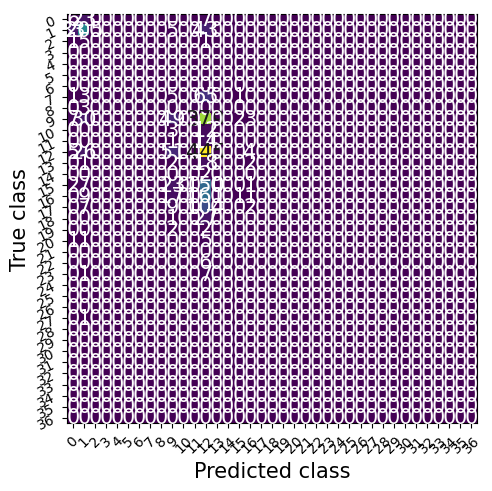

Recall of the custom cnn: tensor(0.0916, device='cuda:0')
F1-score of the custom cnn: tensor(0.0709, device='cuda:0')
Overall accuracy of the custom cnn: tensor(0.0916, device='cuda:0')


In [10]:
preds = torch.Tensor().to(device)
labs = torch.Tensor().to(device)

# Get predictions and corresponding real labels
with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        inp = nnw(inputs)

        preds = torch.cat((preds, inp), 0).to(device)
        labs = torch.cat((labs, labels), 0)
        labs = labs.type(torch.LongTensor).to(device)


# Confusion Matrix
metric = tc.MulticlassConfusionMatrix(37).to(device)
metric.update(preds, labs)

fig_, ax_ = metric.plot()
plt.show()


# Compute recall
recall = tc.Recall(task="multiclass", average='macro', num_classes=37).to(device)
recall(preds, labs)
print("Recall of the custom cnn:", recall.compute())

# Compute F1-score
f1 = tc.MulticlassF1Score(37).to(device)
f1(preds, labs)
print("F1-score of the custom cnn:", f1.compute())


# Compute overall accuracy
oa = tc.MulticlassAccuracy(37).to(device)
oa(preds, labs)
print("Overall accuracy of the custom cnn:", oa.compute())